--- Successfully loaded rain-agriculture.csv ---

--- Time series for RICE PRODUCTION (1000 tons) in Assam ---
Year
1966-01-01    163.244
1967-01-01    178.751
1968-01-01    198.965
1969-01-01    177.557
1970-01-01    198.673
Freq: YS-JAN, Name: RICE PRODUCTION (1000 tons), dtype: float64


Total years of data for Assam: 52
Training data from 1966 to 2006
Testing data from 2007 to 2017


--- ARMA Model Summary ---
                                    SARIMAX Results                                    
Dep. Variable:     RICE PRODUCTION (1000 tons)   No. Observations:                   41
Model:                        SARIMAX(2, 0, 2)   Log Likelihood                -191.879
Date:                         Wed, 13 Aug 2025   AIC                            393.759
Time:                                 06:48:55   BIC                            402.327
Sample:                             01-01-1966   HQIC                           396.879
                                  - 01-01-2006        

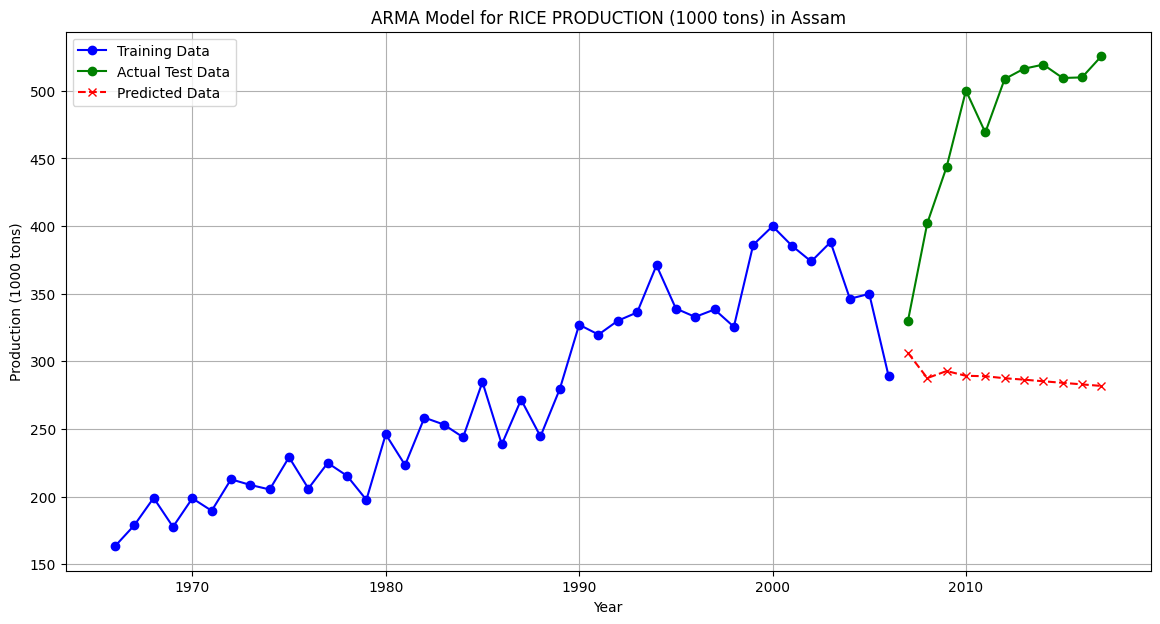

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 1. Load and Prepare the Data ---
try:
    # Load the dataset from the uploaded file
    df = pd.read_csv('rain-agriculture.csv')
    print("--- Successfully loaded rain-agriculture.csv ---")

    # --- Data Cleaning and Preparation ---
    # We will model Rice Production in Assam
    state_to_model = 'assam' # Use lowercase for consistency
    metric_to_model = 'RICE PRODUCTION (1000 tons)'

    # Filter the dataframe for the chosen state
    df['State Name'] = df['State Name'].str.lower()
    state_df = df[df['State Name'] == state_to_model].copy()

    if state_df.empty:
        print(f"Error: No data found for state '{state_to_model.title()}'.")
    else:
        # Create a time series
        state_df.set_index('Year', inplace=True)
        series = state_df[metric_to_model]

        # Handle missing values and set the frequency
        series.fillna(method='ffill', inplace=True)
        series.index = pd.to_datetime(series.index, format='%Y')
        series = series.asfreq('YS')

        print(f"\n--- Time series for {metric_to_model} in {state_to_model.title()} ---")
        print(series.head())
        print("\n")

        # --- 2. Split Data into Training and Testing Sets ---
        split_point = int(len(series) * 0.8)
        train_data, test_data = series[0:split_point], series[split_point:]

        print(f"Total years of data for {state_to_model.title()}: {len(series)}")
        print(f"Training data from {train_data.index.year.min()} to {train_data.index.year.max()}")
        print(f"Testing data from {test_data.index.year.min()} to {test_data.index.year.max()}")
        print("\n")

        # --- 3. Fit the ARMA (Autoregressive Moving Average) Model ---
        # We use the SARIMAX model and set the order to (p, d, q).
        # For a pure ARMA model, the differencing term 'd' is 0.
        # 'p' is the order of the AR part, and 'q' is the order of the MA part.
        # We'll use p=2 and q=2 as a starting point.
        arma_model = SARIMAX(train_data, order=(2, 0, 2))
        arma_model_fit = arma_model.fit(disp=False)

        # Print a summary of the fitted model
        print("--- ARMA Model Summary ---")
        print(arma_model_fit.summary())
        print("\n")

        # --- 4. Make Predictions ---
        predictions = arma_model_fit.get_prediction(start=len(train_data), end=len(train_data) + len(test_data) - 1)
        predictions_mean = predictions.predicted_mean

        # --- 5. Evaluate the Model ---
        rmse = np.sqrt(mean_squared_error(test_data, predictions_mean))
        print(f"--- Model Evaluation ---")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print("\n")

        # --- 6. Visualize the Results ---
        plt.figure(figsize=(14, 7))
        plt.plot(train_data.index.year, train_data, label='Training Data', color='blue', marker='o')
        plt.plot(test_data.index.year, test_data, label='Actual Test Data', color='green', marker='o')
        plt.plot(predictions_mean.index.year, predictions_mean, label='Predicted Data', color='red', linestyle='--', marker='x')
        plt.title(f'ARMA Model for {metric_to_model} in {state_to_model.title()}')
        plt.xlabel('Year')
        plt.ylabel('Production (1000 tons)')
        plt.legend()
        plt.grid(True)
        plt.show()

except FileNotFoundError:
    print("Error: 'rain-agriculture.csv' not found. Please make sure the file is uploaded correctly.")
except KeyError:
    print(f"Error: Make sure the required columns exist in the CSV file.")

